In [180]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("./datasets/sport_cars.csv")
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007 entries, 0 to 1006
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Car Make                 1007 non-null   object
 1   Car Model                1007 non-null   object
 2   Year                     1007 non-null   int64 
 3   Engine Size (L)          997 non-null    object
 4   Horsepower               1007 non-null   object
 5   Torque (lb-ft)           1004 non-null   object
 6   0-60 MPH Time (seconds)  1007 non-null   object
 7   Price (in USD)           1007 non-null   object
dtypes: int64(1), object(7)
memory usage: 63.1+ KB


,Year
count,1007.000000
mean,2021.201589
std,2.019802
min,1965.000000
25%,2021.000000
50%,2021.000000
75%,2022.000000
max,2023.000000


In [181]:
cols_to_clean = [
    "Engine Size (L)",
    "Horsepower",
    "Price (in USD)"
]
for col in cols_to_clean:
    df[col] = (df[col]
               .astype(str)
               .str.replace(",", "", regex=False)
               .str.replace('"', '', regex=False)
               .str.replace('-', '', regex=False)
               .str.strip()
               )
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 948 entries, 0 to 1005
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Car Make                 948 non-null    object 
 1   Car Model                948 non-null    object 
 2   Year                     948 non-null    int64  
 3   Engine Size (L)          948 non-null    float64
 4   Horsepower               948 non-null    float64
 5   Torque (lb-ft)           948 non-null    object 
 6   0-60 MPH Time (seconds)  948 non-null    object 
 7   Price (in USD)           948 non-null    int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 66.7+ KB


In [232]:
y = df["Price (in USD)"]
X = df.drop("Price (in USD)", axis=1)
X = df.drop(columns=['Car Model', "Torque (lb-ft)", '0-60 MPH Time (seconds)'])
X["Car Make"] = X["Car Make"].astype("category")
car_make_norm = pd.get_dummies(X, columns=['Car Make'], drop_first=True)

y.shape, X.shape, X.dtypes

((948,),
 (948, 5),
 Car Make           category
 Year                  int64
 Engine Size (L)     float64
 Horsepower          float64
 Price (in USD)        int64
 dtype: object)

In [246]:
X["Car Make"] = X["Car Make"].astype("category").cat.codes
X['Car Make'].dtypes
X["Car Make"].unique()

array([27, 16, 11,  5, 21,  6, 23,  9, 12, 24,  4,  8, 10, 13, 15, 17, 18,
       19,  1,  3,  7, 22, 25, 26,  0, 20, 28, 33, 35, 29, 31, 30, 14,  2,
       34, 32], dtype=int8)

In [247]:
corel  = X.select_dtypes(include=['number']).corr(method='spearman')
print(corel)

                 Car Make      Year  Engine Size (L)  Horsepower  \
Car Make         1.000000 -0.175390        -0.033518   -0.129353   
Year            -0.175390  1.000000        -0.237182   -0.119435   
Engine Size (L) -0.033518 -0.237182         1.000000    0.604962   
Horsepower      -0.129353 -0.119435         0.604962    1.000000   
Price (in USD)   0.054515 -0.136669         0.321825    0.750535   

                 Price (in USD)  
Car Make               0.054515  
Year                  -0.136669  
Engine Size (L)        0.321825  
Horsepower             0.750535  
Price (in USD)         1.000000  


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [265]:
class MylinearRegression:
    def __init__(self):
        self._coef = None
        self.intercept_ = None 
        self.is_fitted = False
        self.n_features_in = None

    def fit(self, X, y):


        
        if X.ndim == 1:
            X = X.reshape(-1,1)
        elif X.ndim != 2:
            raise ValueError("X must be 1D or 2D array.")
        
        if X.shape[0] != y.shape[0]:
            raise ValueError('X and y must have the same number of samples.')
        


        X = X.astype(float)
        y = y.astype(float)

        
        n_samples, n_features = X.shape
        self.n_features_in = n_samples
        ones = np.ones((n_samples, 1), dtype=float)
        X_b = np.hstack([ones, X])
        XtX = X_b.T @ X_b

        XtY = X_b.T @ y


        beta = np.linalg.pinv(XtX) @ XtY

        self.intercept_ = float(beta[0])

        self.coef_ = beta[1:].reshape(-1)
        self.is_fitted = True
        return self
    

    def predict(self, X):
        if self.is_fitted == False:
            raise RuntimeError("fun fit() before predict()")
        X = np.asarray(X)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        elif X.ndim != 2:
            raise ValueError("X must be 1D or 2D array.")

        if X.shape[1] != self.coef_.shape[0]:
            raise ValueError(
                f"Number of features in X ({X.shape[1]}) does not match "
                f"the fitted model ({self.coef_.shape[0]})."
            )
        
        X = X.astype(float)
        y_pred = X @ self.coef_ + self.intercept_
        return y_pred
        
        

In [266]:
print(X.shape)
print(y.shape)

(948, 5)
(948,)


In [267]:
mymodel = MylinearRegression()
pipe = Pipeline([
    ("scaler",  StandardScaler()),
    ('ling', mymodel)
])

pipe.fit(X_train, y_train)

print("Slope: ", pipe.named_steps["ling"].coef_)
print("Bias: ", pipe.named_steps["ling"].intercept_)

Slope:  [1.04591891e-11 3.63797881e-11 9.45874490e-11 0.00000000e+00
 6.97368641e+05]
Bias:  348922.1015831134


In [268]:
# condition number very high in e+21
X = X.astype(float)
np.linalg.cond(X)

np.float64(607388.6566179672)

In [273]:
def msee(y_true, y_pred):
    return ((y_true - y_pred)**2).mean()

In [274]:
y_pred = pipe.predict(X_test)
mse = msee(y_test, y_pred)
print("MSE: ", mse)

MSE:  2.826861009757641e-20


In [275]:
print(X_train.shape, X_test.shape)

(758, 5) (190, 5)


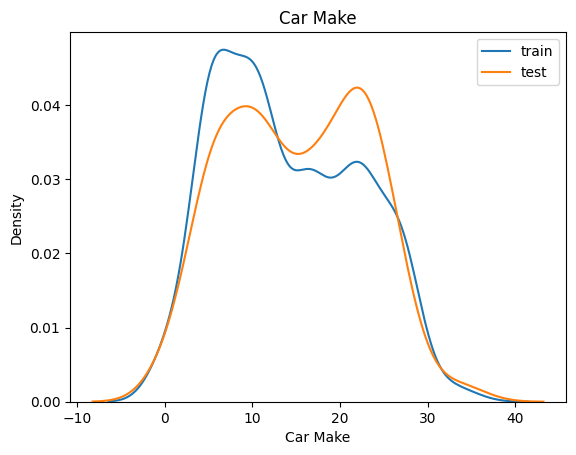

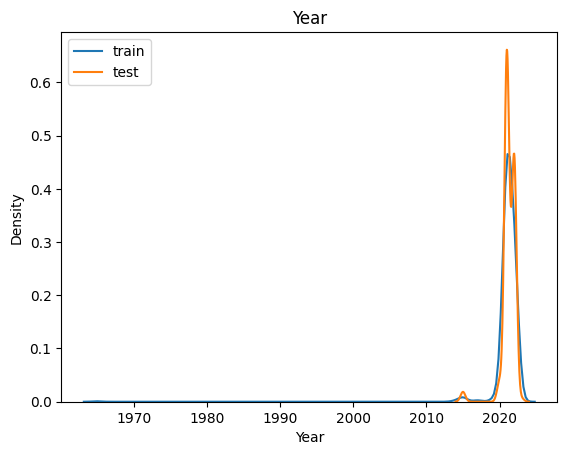

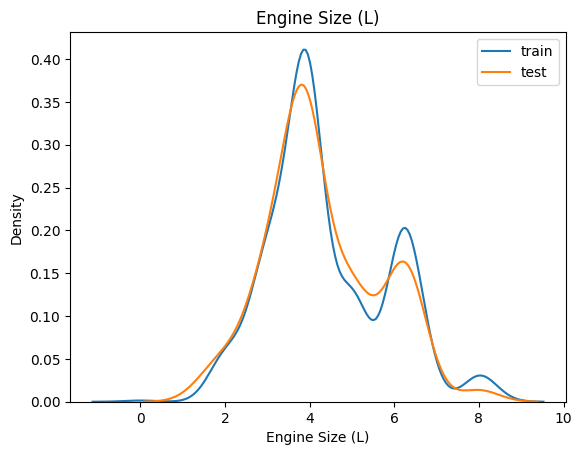

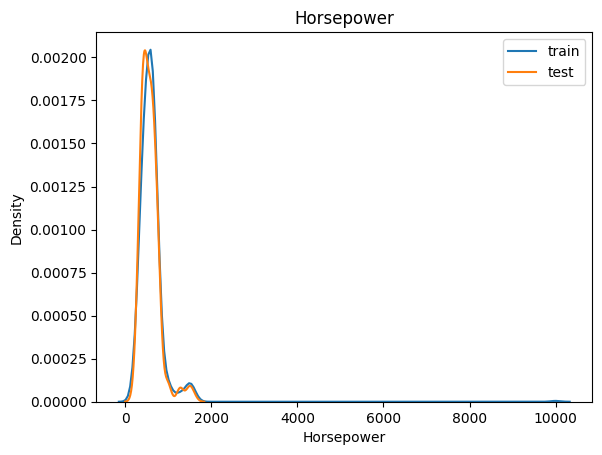

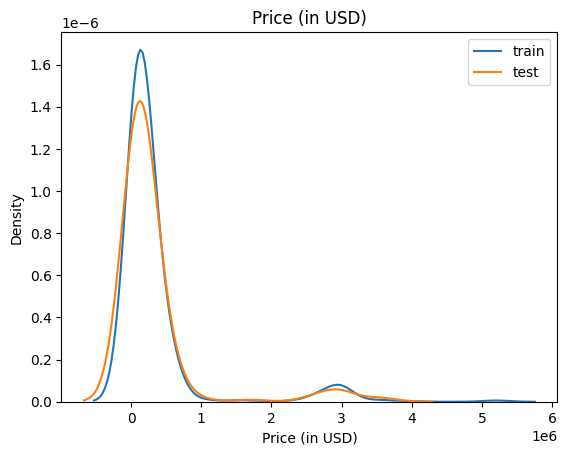

In [276]:
import seaborn as sns
for col in X.columns:
    sns.kdeplot(X_train[col], label='train')
    sns.kdeplot(X_test[col], label='test')
    plt.title(col)
    plt.legend()
    plt.show()
